In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import flax.linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import seaborn as sns
from flax.training import train_state
from jax import random
from sklearn.manifold import TSNE

from neurovae import Conv2DVAE, bce_loss, gaussian_kld, load_mnist, reparameterize
from helper import fig_path

sns.set_theme(context="paper", style="darkgrid", rc={"axes.facecolor": "0.96"})
fontsize = "x-large"
params = {
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "legend.handlelength": 2,
}
plt.rcParams.update(params)

2024-06-24 04:59:13.403763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [23]:
beta = 2
latent_dim = 20
batch_size = 64
epochs = 100
seed = 42

batches, train_labels, ds_test, test_labels = load_mnist(
    batch_size=batch_size,
    drop_remainder=True,
    select_digits=[0, 1, 2, 3],
    as_supervised=True,
    binarized=True,
    shuffle=True,
    shuffle_seed=42,
)

# set values for learning rate scheduler
total_steps = len(batches) * epochs
init_lr = 1e-3
alpha_lr = 1e-2

ds_test = ds_test.reshape(-1, 28, 28, 1)
ds_test = jax.device_put(ds_test)

def model():
    return Conv2DVAE(latent_dim)

def init_model(rng):
    rng, init_key = random.split(rng)

    initial_variables = jnp.ones((batch_size, 28, 28, 1), jnp.float32)
    params = model().init(init_key, initial_variables, rng)["params"]
    del initial_variables, init_key

    lr_schedule = optax.cosine_decay_schedule(init_lr, decay_steps=total_steps, alpha=alpha_lr)
    optimizer = optax.chain(optax.clip(1.0), optax.adamw(lr_schedule, nesterov=True))

    state = train_state.TrainState.create(
        apply_fn=model().apply,
        params=params,
        tx=optimizer,
    )
    return rng, state

def compute_metrics(recon_x, x, mean, logvar):
    bce = bce_loss(recon_x, x).mean()  # mean over batch
    kld = gaussian_kld(mean, logvar).mean()  # mean over batch
    elbo = bce + beta * kld
    return {"elbo": elbo, "bce": bce, "kld": kld}

@jax.jit
def train_step(state, batch, z_rng):

    def loss_fn(params):
        recon_x, mean, logvar = model().apply({"params": params}, batch, z_rng)
        bce = bce_loss(recon_x, batch).mean()
        kld = gaussian_kld(mean, logvar).mean()
        elbo = bce + beta * kld
        return elbo

    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)

@jax.jit
def eval_f(params, images, z, z_rng):
    def eval_model(vae):
        recon_images, mean, logvar = vae(images, z_rng)

        recon_images_compare = nn.sigmoid(recon_images[:8])
        comparison = jnp.concatenate(
            [
                images[:8],
                recon_images_compare,
            ]
        )

        generate_images = vae.generate(z, assumption="bernoulli")
        generate_images = generate_images
        metrics = compute_metrics(recon_images, images, mean, logvar)
        return metrics, comparison, generate_images

    return nn.apply(eval_model, model())({"params": params})

rng = random.key(seed)
rng, state = init_model(rng)

rng, z_key, eval_rng = random.split(rng, 3)

z = random.normal(z_key, (batch_size, latent_dim))  # prior
del z_key

epoch_metrics = []
for epoch in range(epochs):
    for batch in batches:
        batch = batch.reshape(-1, 28, 28, 1)
        rng, key = random.split(rng)
        state = train_step(state, batch, key)

    metrics, comparison, samples = eval_f(state.params, ds_test, z, eval_rng)
    metrics["epoch"] = epoch + 1
    epoch_metrics.append(metrics)
    print(f"epoch: {epoch + 1}, ELBO: {metrics['elbo']:.4f}, BCE: {metrics['bce']:.4f}, KLD: {metrics['kld']:.4f}")


epoch: 1, ELBO: 126.6135, BCE: 90.6564, KLD: 17.9785
epoch: 2, ELBO: 114.7066, BCE: 78.5298, KLD: 18.0884
epoch: 3, ELBO: 112.7670, BCE: 73.7692, KLD: 19.4989
epoch: 4, ELBO: 107.2046, BCE: 69.5412, KLD: 18.8317
epoch: 5, ELBO: 105.3050, BCE: 66.3211, KLD: 19.4919
epoch: 6, ELBO: 104.2436, BCE: 65.7093, KLD: 19.2671
epoch: 7, ELBO: 103.2821, BCE: 65.5454, KLD: 18.8684
epoch: 8, ELBO: 102.5610, BCE: 62.9737, KLD: 19.7936
epoch: 9, ELBO: 102.1083, BCE: 62.6503, KLD: 19.7290
epoch: 10, ELBO: 101.3655, BCE: 61.6837, KLD: 19.8409
epoch: 11, ELBO: 100.3924, BCE: 61.0872, KLD: 19.6526
epoch: 12, ELBO: 100.2537, BCE: 61.0282, KLD: 19.6128
epoch: 13, ELBO: 99.7245, BCE: 60.5345, KLD: 19.5950
epoch: 14, ELBO: 99.0163, BCE: 59.8359, KLD: 19.5902
epoch: 15, ELBO: 99.1079, BCE: 59.2482, KLD: 19.9299
epoch: 16, ELBO: 98.3965, BCE: 60.3706, KLD: 19.0130
epoch: 17, ELBO: 98.2587, BCE: 59.5336, KLD: 19.3626
epoch: 18, ELBO: 97.9944, BCE: 59.5648, KLD: 19.2148
epoch: 19, ELBO: 97.8431, BCE: 58.1064, KLD

In [24]:
enc_rng = random.key(seed*seed)
_, mean, logvar = model().apply({"params": state.params}, ds_test, enc_rng)
z = reparameterize(enc_rng, mean, logvar)
z = np.array(z)
test_labels = np.array(test_labels)


In [25]:
z_embedded = TSNE(n_components=2, learning_rate="auto", perplexity=30, early_exaggeration=12.0).fit_transform(z)

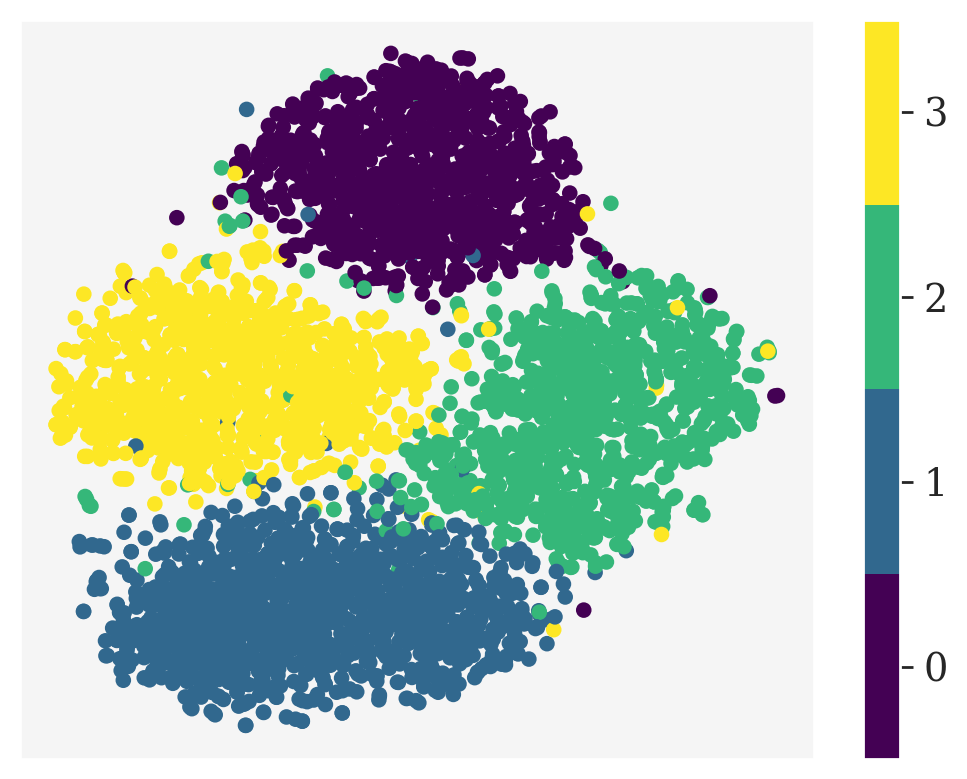

In [26]:
fig = plt.figure()
plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=test_labels, cmap="viridis")
plt.colorbar(boundaries=np.arange(5) - 0.5).set_ticks(np.arange(4))
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
fig.savefig(fig_path(f"tsne_beta_{beta}_vae.pdf"), bbox_inches="tight")